In [2]:
import os, os.path as osp
import random
import sys
sys.path.insert(0, osp.abspath(osp.pardir))
print(sys.path)
import numpy as np
import matplotlib.pyplot as plt
import torch, dgl

['/work2/08723/tianhaoh/shared/GNNoS', '/work2/08723/tianhaoh/shared/GNNoS/notebooks', '', '/opt/apps/intel19/impi19_0/python3/3.7.0/lib/python3.7/site-packages', '/work2/08723/tianhaoh/frontera/miniconda3/envs/gnn/lib/python39.zip', '/work2/08723/tianhaoh/frontera/miniconda3/envs/gnn/lib/python3.9', '/work2/08723/tianhaoh/frontera/miniconda3/envs/gnn/lib/python3.9/lib-dynload', '/work2/08723/tianhaoh/frontera/miniconda3/envs/gnn/lib/python3.9/site-packages']


In [3]:
import dgl.function as fn

class NodePartitioner(object):
    def __init__(self, name):
        self.name = name

    def partition(self, g, psize):
        raise NotImplementedError

class RandomNodePartitioner(NodePartitioner):
    def __init__(self):
        super().__init__('rand')

    def partition(self, g, psize):
        return torch.randint(psize, (g.num_ndoes(),))

class MetisNodePartitioner(NodePartitioner):
    def __init__(self, name='metis'):
        super().__init__(name)

    def partition(self, g, psize, mask=None, objtype='cut'):
        return dgl.metis_partition_assignment(g, psize, mask, objtype=objtype)

class MetisMinCutBalanced(MetisNodePartitioner):
    def __init__(self):
        super().__init__(name='metis-cut')

    def partition(self, g, psize):
        return super().partition(g, psize, g.ndata['train_mask'].int(), objtype='cut')
    
class MetisMinVolBalanced(MetisNodePartitioner):
    def __init__(self):
        super().__init__(name='metis-vol')

    def partition(self, g, psize):
        return super().partition(g, psize, g.ndata['train_mask'].int(), objtype='vol')

def partition_from(ids, assigns, psize):
    '''
    return ids of each part in a list given the assignments
    '''
    assert ids.shape == assigns.shape
    _, idx = torch.sort(assigns)
    shuffled = ids[idx]

    # compute partition sizes
    group_sizes = torch.histc(assigns.float(), bins=psize, min=0, max=psize).long()
    group_offs = torch.cumsum(group_sizes, dim=0)
    groups = [shuffled[:group_offs[0]]]
    for i in range(1, len(group_offs)):
        groups.append(shuffled[group_offs[i-1]:group_offs[i]])

    return groups

def edge_cuts_from(g, assigns, psize):
    '''
    return #edge cuts between pairs of partitions
    u -[e]-> v: id(e) = id(u) * psize + id(v)
    '''
    assert g.num_nodes() == assigns.shape[0]
    with g.local_scope():
        g.ndata['vp'] = assigns.float()
        g.ndata['vp_p'] = g.ndata['vp'] * psize
        g.apply_edges(fn.u_add_v('vp', 'vp_p', 'ep'))
        edge_part_sizes = torch.histc(g.edata['ep'], bins=psize*psize, min=0, max=psize*psize)
        return edge_part_sizes.reshape((psize,psize))

def train_edge_cuts_from(g, assigns, psize):
    '''
    return #edge cuts between pairs of partitions
    u -[e]-> v: id(e) = id(u) * psize + id(v)
    '''
    assert g.num_nodes() == assigns.shape[0]
    train_mask = g.ndata['train_mask']
    with g.local_scope():
        g.ndata['t_p'] = -1 * torch.ones(g.num_nodes())
        g.ndata['t_p'][train_mask] = assigns[train_mask].float()
        g.ndata['t_p'] = g.ndata['t_p'] * psize
        g.ndata['nt_p'] = assigns.float()
        g.apply_edges(fn.u_add_v('t_p', 'nt_p', 'e_p'))
        edge_part_sizes = torch.histc(g.edata['e_p'], bins=psize*psize, min=0, max=psize*psize)
        return edge_part_sizes.reshape((psize,psize))

def lazy_rw(g, roots, steps, alpha=0.85):
    '''
    perform lazy random walk from roots for some steps, with prob=alpha to move forward
    return a probability distribution of the random walk ended at certain nodes
    '''
    with g.local_scope():
        g.ndata['rw_p'] = torch.zeros(g.num_nodes(), dtype=torch.float)
        g.ndata['rw_p'][roots] = 1
        deg = g.in_degrees()
        for i in range(steps):
            g.ndata['msg'] = g.ndata['rw_p'] * alpha / deg
            g.update_all(fn.copy_u('msg', 'm'), fn.sum('m', 'rw_next'))
            g.ndata['rw_p'] = g.ndata['rw_p'] * (1-alpha) + g.ndata['rw_next']
        return g.ndata['rw_p'] / g.ndata['rw_p'].sum()

# ClusterIter without random permutation of partitions - for profling purposes
class ClusterIter(object):
    '''
    The partition sampler given a DGLGraph and partition number.
    The metis/other partitioners is used as the graph partition backend.
    The sampler returns a subgraph induced by a batch of clusters
    '''
    def __init__(self, dataset, g, psize, bsize, hsize, partitioner=RandomNodePartitioner(),
            sample_helpers=False, sample_topk=False, rw=False, ext_deg=False, popular_ratio=0):
        self.g = g
        self.psize = psize
        self.bsize = bsize
        self.hsize = hsize
        self.sample_topk = sample_topk
        self.sample_helpers = sample_helpers

        cache_folder = os.path.join(os.environ['DATASETS'], "partition",
                dataset, partitioner.name)
        os.makedirs(cache_folder, exist_ok=True)
        cache_file = f'{cache_folder}/p{psize}.pt'

        nids = g.nodes()
        train_nids = nids[g.ndata['train_mask']]
        if os.path.exists(cache_file):
            self.assigns = torch.load(cache_file)
        else:
            self.assigns = partitioner.partition(g, psize)
            torch.save(self.assigns, cache_file)
        nontrain_mask = ~g.ndata['train_mask']
        self.parts = partition_from(nids[nontrain_mask], self.assigns[nontrain_mask], psize)
        train_assigns = self.assigns[train_nids]
        self.train_parts = partition_from(train_nids, train_assigns, psize)
        self.train_nids = train_nids

        # print("Computing partition sampling weights...")
        # self.cuts = train_edge_cuts_from(g, self.assigns, psize)

        self.max = int((self.psize) // self.bsize)
        # disable shuffling for stat purposes
        self.train_pids = torch.arange(self.psize)

        self.node_budget = int(popular_ratio * g.num_nodes())
        if ext_deg:
            print("node prob based on external degrees")
            assigns = self.assigns / (psize // bsize)
            self.node_prob = self.__compute_ext_deg__(assigns)
        elif rw:
            steps, alpha=3, 0.85
            print(f"node prob based on lazy rw[{(steps, alpha)}]")
            self.node_prob = lazy_rw(self.g, self.train_nids, steps=steps, alpha=alpha)
        else:
            print(f"node prob based on degrees")
            self.node_prob = self.g.in_degrees().float().clamp(min=1)
        self.node_prob = self.node_prob / self.node_prob.sum()
        self.node_cache_parts = self.__get_pst_cache__()

    def __compute_ext_deg__(self, assigns):
        '''
        compute ext-deg(v)=deg(v)-deg_p(v), where p is the partition v belongs to
        '''
        with g.local_scope():
            g.ndata['pid'] = assigns.float()
            g.apply_edges(fn.u_sub_v('pid', 'pid', 'diff'))
            g.edata['diff'] = (g.edata['diff'] == 0).float()
            g.update_all(fn.copy_e('diff', 'm'), fn.sum('m', 'd_i'))
            return g.in_degrees() - g.ndata['d_i']
    
    def __get_pst_cache__(self):
        if self.sample_topk:
            node_cache = torch.from_numpy(
                     np.random.choice(np.arange(self.g.num_nodes(), dtype=np.int64),
                         size=self.node_budget, p=self.node_prob.numpy(), replace=False)
                     )
        else:
            node_cache = torch.topk(self.node_prob, self.node_budget).indices
        # print("node cache degrees:", self.g.in_degrees(node_cache).sum().item())
        return partition_from(node_cache, self.assigns[node_cache], self.psize)

    '''
    def precalc(self, g):
        norm = self.get_norm(g)
        g.ndata['norm'] = norm
        features = g.ndata['feat']
        with torch.no_grad():
            g.update_all(fn.copy_src(src='feat', out='m'),
                         fn.sum(msg='m', out='feat'),
                         None)
            pre_feats = g.ndata['feat'] * norm
            # use graphsage embedding aggregation style
            g.ndata['feat'] = torch.cat([features, pre_feats], dim=1)

    # use one side normalization
    def get_norm(self, g):
        norm = 1. / g.in_degrees().float().unsqueeze(1)
        norm[torch.isinf(norm)] = 0
        norm = norm.to(self.g.ndata['feat'].device)
        return norm
    '''

    def __len__(self):
        return self.max

    def __iter__(self):
        self.n = 0
        return self

    def __next__(self):
        if self.n < self.max:
            sample_pids = self.train_pids[self.n*self.bsize : (self.n+1)*self.bsize]
            train_nids = torch.cat([self.train_parts[pid] for pid in sample_pids])
            # we use fixed helpers policy
            helper_nids = torch.cat([self.parts[i] for i in sample_pids])
            cache_parts = [self.node_cache_parts[i] for i in range(self.psize) if i not in sample_pids]
            cache_nids = torch.cat(cache_parts)
            nids = torch.cat([train_nids, helper_nids, cache_nids])
            # print(len(train_nids), len(helper_nids), len(cache_nids))
            # XXX: check cache_nids don't duplicate with other nodes
            assert len(torch.unique(nids)) == len(nids)

            subgraph = dgl.node_subgraph(self.g, nids)
            sg_num_nodes = subgraph.num_nodes()
            sg_train_nids = torch.arange(train_nids.shape[0])
            sg_cache_nids = torch.arange(sg_num_nodes-len(cache_nids), sg_num_nodes)
            # XXX: verify all sg_train_nids has train_mask
            assert (subgraph.ndata['train_mask'][sg_train_nids] == True).all().item()
            subgraph.ndata['train_mask'][:] = False
            subgraph.ndata['train_mask'][sg_train_nids] = True
            subgraph.ndata['cache_mask'] = torch.BoolTensor(sg_num_nodes)
            subgraph.ndata['cache_mask'][:] = False
            subgraph.ndata['cache_mask'][sg_cache_nids] = True
            self.n += 1
            return subgraph
        else:
            # self.train_pids = torch.randperm(self.psize)
            self.node_cache_parts = self.__get_pst_cache__()
            raise StopIteration


In [7]:
def get_degree_dist(subgraph, graph):
    '''
    get degree distributions for nodes in the subgraph
    and in the original graph g
    '''
    train_mask = subgraph.ndata['train_mask']
    cache_mask = subgraph.ndata['cache_mask']
    noncache_mask = ~cache_mask
    sg_nodes = subgraph.nodes()
    sg_train_nodes = sg_nodes[train_mask]
    sg_cache_nodes = sg_nodes[cache_mask]
    sg_0c_nodes = sg_nodes[noncache_mask]
    
    sg_nid_groups = [sg_nodes, sg_train_nodes, sg_0c_nodes, sg_cache_nodes]
    g_nid_groups = [ subgraph.ndata[dgl.NID][group] for group in sg_nid_groups ]
    sg_dist_groups = [subgraph.in_degrees(group) for group in sg_nid_groups]
    g_dist_groups = [graph.in_degrees(group) for group in g_nid_groups]
    
    series = ['all', 'train', 'dyn', 'pst']
    entries = ['sg_nid', 'nid', 'sg_dist', 'dist']
    data_series = list(zip(sg_nid_groups, g_nid_groups, sg_dist_groups, g_dist_groups))
    data_series = [dict(zip(entries, data)) for data in data_series]
    data_series = dict(zip(series, data_series))
    
    # sanity check: sg_dist <= global dist
    for k in ['all', 'train', 'dyn']:
        sg_dist = data_series[k]['sg_dist']
        dist = data_series[k]['dist']
        assert (sg_dist <= dist).all().item() is True
    
    return data_series

def degree_diff(metis_c0_iter, metis_c1_iter, rand_c0_iter, rand_c1_iter, iters, fanout, ntype='dyn'):
    mlist = []
    rlist = []
    
    for i in range(len(metis_c0_iter)):
        if i not in iters:
            next(metis_c0_iter)
            next(metis_c1_iter)
            next(rand_c0_iter)
            next(rand_c1_iter)
            continue
        
        ###### metis partitioning ###### 
        sg_c0, sg_c1 = next(metis_c0_iter), next(metis_c1_iter)
        dist_c0 = get_degree_dist(sg_c0, g)
        dist_c1 = get_degree_dist(sg_c1, g)
        # make sure they contain the same dynamic cache nodes
        assert (dist_c0['dyn']['dist'] == dist_c1['dyn']['dist']).all().item() is True

        c0_below = dist_c0[ntype]['sg_dist'] < fanout
        c0_above = dist_c0[ntype]['sg_dist'] >= fanout
        c1_below = dist_c1[ntype]['sg_dist'] < fanout
        c1_above = dist_c1[ntype]['sg_dist'] >= fanout
        dist_g = dist_c0[ntype]['dist']
        g_below = dist_g < fanout
        g_above = dist_g >= fanout

        # Part1: always above
        p1 = (c0_above & c1_above & g_above).int().sum().item()
        # Part2: c0 below, c1, g above
        p2 = (c0_below & c1_above & g_above).int().sum().item()
        # Part3: c0 below, c1 below, g above
        p3 = (c0_below & c1_below & g_above).int().sum().item()
        # Part4: all below
        p4 = (c0_below & c1_below & g_below).int().sum().item()
        # Part5: c0 above, c1 below, g above, only >0 for pst cache nodes
        p5 = (c0_above & c1_below & g_above).int().sum().item()

        # also compute deg sum
        deg_sum_c0 = dist_c0[ntype]['sg_dist'].sum().item()
        deg_sum_c1 = dist_c1[ntype]['sg_dist'].sum().item()
        
        mlist.append([p1, p2, p3, p4, p5, deg_sum_c0, deg_sum_c1])
        # print('Metis:', mlist[-1])

        ###### random partitioning ###### 
        sg_c0, sg_c1 = next(rand_c0_iter), next(rand_c1_iter)
        dist_c0 = get_degree_dist(sg_c0, g)
        dist_c1 = get_degree_dist(sg_c1, g)
        # make sure they contain the same dynamic cache nodes
        assert (dist_c0['dyn']['dist'] == dist_c1['dyn']['dist']).all().item() is True

        c0_below = dist_c0[ntype]['sg_dist'] < fanout
        c0_above = dist_c0[ntype]['sg_dist'] >= fanout
        c1_below = dist_c1[ntype]['sg_dist'] < fanout
        c1_above = dist_c1[ntype]['sg_dist'] >= fanout
        dist_g = dist_c0[ntype]['dist']
        g_below = dist_g < fanout
        g_above = dist_g >= fanout

        # Part1: always above
        p1 = (c0_above & c1_above & g_above).int().sum().item()
        # Part2: c0 below, c1, g above
        p2 = (c0_below & c1_above & g_above).int().sum().item()
        # Part3: c0 below, c1 below, g above
        p3 = (c0_below & c1_below & g_above).int().sum().item()
        # Part4: all below
        p4 = (c0_below & c1_below & g_below).int().sum().item()
        # Part5: c0 above, c1 below, g above, only >0 for pst cache nodes
        p5 = (c0_above & c1_below & g_above).int().sum().item()
        
        # also compute deg sum
        deg_sum_c0 = dist_c0[ntype]['sg_dist'].sum().item()
        deg_sum_c1 = dist_c1[ntype]['sg_dist'].sum().item()

        rlist.append([p1, p2, p3, p4, p5, deg_sum_c0, deg_sum_c1])
        # print('Random:', rlist[-1])

    return [sum(ps) for ps in zip(*mlist)], [sum(ps) for ps in zip(*rlist)]

def pie_chart(ax, counts, dataset, psize, bsize, part, pratio):
    ax.

In [12]:
import graphloader
dataset='ogbn-papers100M'
dataset_dir = osp.join(os.environ['DATASETS'], 'baseline')
graphdata = graphloader.GraphLoader(name=dataset, root=dataset_dir, mmap=False)
g = graphdata.graph
print(g)

Graph(num_nodes=111059956, num_edges=3228124712,
      ndata_schemes={'label': Scheme(shape=(1,), dtype=torch.float32), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'valid_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={})


In [ ]:
psize=16384
bsize=1024
pratio=0.01
fanout = 10
iters = range(3)
# iters = torch.randint(psize//bsize, (3,))

# create cluster dataloaders with Metis min-cut
metis_c0_iter = ClusterIter(dataset, g, psize=psize, bsize=bsize, hsize=bsize,
                            partitioner=MetisNodePartitioner(), popular_ratio=0).__iter__()
metis_c1_iter = ClusterIter(dataset, g, psize=psize, bsize=bsize, hsize=bsize,
                            partitioner=MetisNodePartitioner(), popular_ratio=pratio).__iter__()
rand_c0_iter = ClusterIter(dataset, g, psize=psize, bsize=bsize, hsize=bsize,
                           partitioner=RandomNodePartitioner(), popular_ratio=0).__iter__()
rand_c1_iter = ClusterIter(dataset, g, psize=psize, bsize=bsize, hsize=bsize,
                           partitioner=RandomNodePartitioner(), popular_ratio=pratio).__iter__()

degree_diff(metis_c0_iter, metis_c1_iter, rand_c0_iter, rand_c1_iter, iters=iters, fanout=fanout, ntype='dyn')

In [9]:
# create cluster dataloaders with Metis min-cut, use external degree metric
metis_c0_iter = ClusterIter(dataset, g, psize=psize, bsize=bsize, hsize=bsize, ext_deg=True,
                            partitioner=MetisNodePartitioner(), popular_ratio=0).__iter__()
metis_c1_iter = ClusterIter(dataset, g, psize=psize, bsize=bsize, hsize=bsize, ext_deg=True,
                            partitioner=MetisNodePartitioner(), popular_ratio=pratio).__iter__()
rand_c1_iter = ClusterIter(dataset, g, psize=psize, bsize=bsize, hsize=bsize, ext_deg=True,
                           partitioner=RandomNodePartitioner(), popular_ratio=pratio).__iter__()
rand_c0_iter = ClusterIter(dataset, g, psize=psize, bsize=bsize, hsize=bsize, ext_deg=True,
                           partitioner=RandomNodePartitioner(), popular_ratio=0).__iter__()

degree_diff(metis_c0_iter, metis_c1_iter, rand_c0_iter, rand_c1_iter, iters=iters, fanout=fanout, ntype='dyn')

node prob based on external degrees
node prob based on external degrees
node prob based on external degrees
node prob based on external degrees


([28845, 16100, 17701, 106697, 0, 1065302, 1431340],
 [375, 18365, 43906, 106697, 0, 72260, 552566])

In [ ]:
# create cluster dataloaders with Metis min-vol
metis_c0_iter = ClusterIter(dataset, g, psize=psize, bsize=bsize, hsize=bsize,
                            partitioner=MetisMinVolBalanced(), popular_ratio=0).__iter__()
metis_c1_iter = ClusterIter(dataset, g, psize=psize, bsize=bsize, hsize=bsize,
                            partitioner=MetisMinVolBalanced(), popular_ratio=pratio).__iter__()
rand_c1_iter = ClusterIter(dataset, g, psize=psize, bsize=bsize, hsize=bsize,
                           partitioner=RandomNodePartitioner(), popular_ratio=pratio).__iter__()
rand_c0_iter = ClusterIter(dataset, g, psize=psize, bsize=bsize, hsize=bsize,
                           partitioner=RandomNodePartitioner(), popular_ratio=0).__iter__()

degree_diff(metis_c0_iter, metis_c1_iter, rand_c0_iter, rand_c1_iter, iters=iters, fanout=fanout, ntype='dyn')

In [11]:
# create cluster dataloaders with Metis min-vol, use external degree metric
metis_c0_iter = ClusterIter(dataset, g, psize=psize, bsize=bsize, hsize=bsize, ext_deg=True,
                            partitioner=MetisMinVolBalanced(), popular_ratio=0).__iter__()
metis_c1_iter = ClusterIter(dataset, g, psize=psize, bsize=bsize, hsize=bsize, ext_deg=True,
                            partitioner=MetisMinVolBalanced(), popular_ratio=pratio).__iter__()
rand_c1_iter = ClusterIter(dataset, g, psize=psize, bsize=bsize, hsize=bsize, ext_deg=True,
                           partitioner=RandomNodePartitioner(), popular_ratio=pratio).__iter__()
rand_c0_iter = ClusterIter(dataset, g, psize=psize, bsize=bsize, hsize=bsize, ext_deg=True,
                           partitioner=RandomNodePartitioner(), popular_ratio=0).__iter__()

degree_diff(metis_c0_iter, metis_c1_iter, rand_c0_iter, rand_c1_iter, iters=iters, fanout=fanout, ntype='dyn')

node prob based on external degrees
node prob based on external degrees
node prob based on external degrees
node prob based on external degrees


([34508, 13536, 14602, 106697, 0, 1222300, 1558627],
 [375, 18365, 43906, 106697, 0, 72260, 552566])

In [63]:
# create cluster dataloaders, use rw probability to sample pst cache
metis_c0_iter = ClusterIter(dataset, g, psize=psize, bsize=bsize, hsize=bsize, rw=True,
                            partitioner=MetisBalancedPartitioner(), popular_ratio=0).__iter__()
metis_c1_iter = ClusterIter(dataset, g, psize=psize, bsize=bsize, hsize=bsize, rw=True,
                            partitioner=MetisBalancedPartitioner(), popular_ratio=pratio).__iter__()
rand_c1_iter = ClusterIter(dataset, g, psize=psize, bsize=bsize, hsize=bsize, rw=True,
                           partitioner=RandomNodePartitioner(), popular_ratio=pratio).__iter__()
rand_c0_iter = ClusterIter(dataset, g, psize=psize, bsize=bsize, hsize=bsize, rw=True,
                           partitioner=RandomNodePartitioner(), popular_ratio=0).__iter__()

degree_diff(metis_c0_iter, metis_c1_iter, rand_c0_iter, rand_c1_iter, iters=iters, fanout=fanout, ntype='dyn')

node prob based on lazy rw[(3, 0.85)]
node prob based on lazy rw[(3, 0.85)]
node prob based on lazy rw[(3, 0.85)]
node prob based on lazy rw[(3, 0.85)]


([25755, 13198, 23693, 106697, 0], [135, 8624, 53887, 106697, 0])

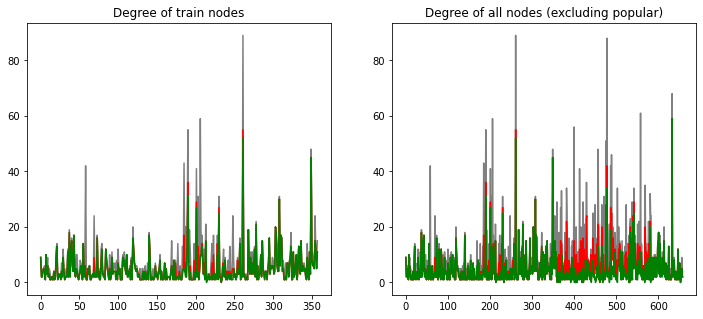

In [114]:
plt.rcParams['figure.figsize'] = [12, 5]
plt.figure()
ax = plt.subplot(121)
ax.set_title("Degree of train nodes")
ax.plot(dist_c0[1][3], color='gray')
ax.plot(dist_c1[1][2], color='r')
ax.plot(dist_c0[1][2], color='green')

ax = plt.subplot(122)
ax.set_title("Degree of all nodes (excluding p-cache)")
ax.plot(dist_c0[2][3], color='gray')
ax.plot(dist_c1[2][2], color='r')
ax.plot(dist_c0[2][2], color='green')
plt.show()

In [61]:
def intra_inter_degrees(g, node_set):
    deg_sum = g.in_degrees(node_set).sum()
    sg = g.subgraph(node_set)
    intra_deg = sg.in_degrees().sum()
    return intra_deg, deg_sum - intra_deg

intra_inter_degrees(metis_c1_iter.g, torch.cat(metis_c1_iter.node_cache_parts))

(tensor(44346), tensor(451436))

<Figure size 432x288 with 0 Axes>

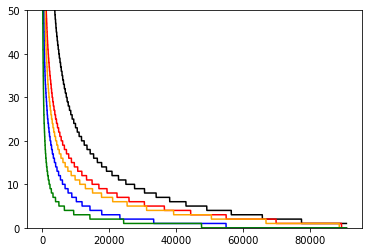

In [34]:
plt.figure()
_, metis_sg_c1, g_dist = degree_dist(metis_c1_iter, g)
_, metis_sg_c0, _ = degree_dist(metis_c0_iter, g)
_, rand_sg_c1, _ = degree_dist(rand_c1_iter, g)
_, rand_sg_c0, _ = degree_dist(rand_c0_iter, g)
plt.figure()

g_sorted, _ = torch.sort(metis_g_dist, descending=True)
metis_c1_sorted, _ = torch.sort(metis_sg_c1, descending=True)
metis_c0_sorted, _ = torch.sort(metis_sg_c0, descending=True)
rand_c1_sorted, _ = torch.sort(rand_sg_c1, descending=True)
rand_c0_sorted, _ = torch.sort(rand_sg_c0, descending=True)
plt.plot(g_sorted, color='black')
plt.plot(metis_c1_sorted, color='red')
plt.plot(metis_c0_sorted, color='orange')
plt.plot(rand_c1_sorted, color='blue')
plt.plot(rand_c0_sorted, color='green')
plt.ylim([0, 50])
plt.show()

In [6]:
seeds = torch.randint(g.num_nodes(), (32,))
print("Seed nodes to start sampling with:")
print(seeds)

Seed nodes to start sampling with:
tensor([1300887, 2099796, 2418273, 1632254, 1366510, 1241817, 1395205, 1757922,
         344507, 2110793, 2446189, 1886552, 1636847,  544967,  475622,  442955,
        1457436, 2046614, 1496639,  157365,  941564, 1344644, 2125957, 2128770,
        1856015,  626054,  103844, 1597071, 1000066, 2376133,  925419,  627206])
